In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

Number of rows with missing values: 0.0


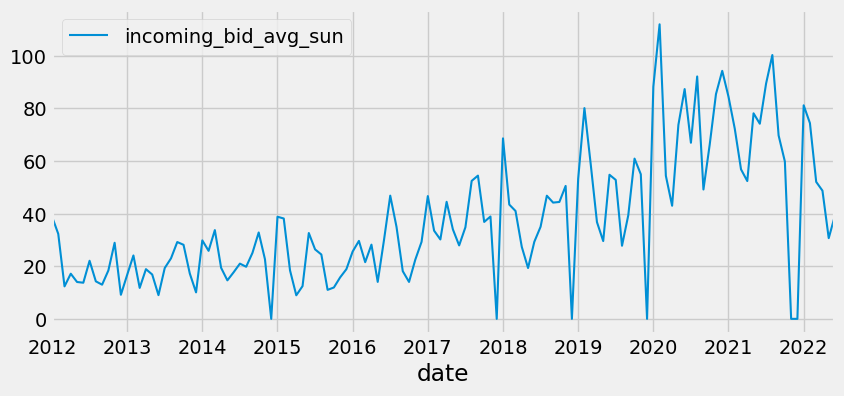

In [2]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/arifpras/forecastingDemand/main/20230126_database.csv')
data = pd.read_csv(url, sep=',', header=0, names=['month', 'incoming_bid_avg_sun', 'incoming_bid_avg_sbn', 'dpk_bankumum', 'dv_bankindonesia', 'vix_index', 'bfcius_bberg'])

# Data preparation
# ==============================================================================
data = data.rename(columns={'month': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'incoming_bid_avg_sun': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

fig, ax = plt.subplots(figsize=(9, 4))
data['y'].plot(ax=ax, label='incoming_bid_avg_sun')
ax.legend();

In [3]:
# Split data into train-test
# ==============================================================================
steps = 12
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2012-01-01 00:00:00 --- 2021-06-01 00:00:00  (n=114)
Test dates  : 2021-07-01 00:00:00 --- 2022-06-01 00:00:00  (n=12)


In [4]:
# Function to calculate predictors from time series
# ==============================================================================
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

In [5]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: custom_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2021-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-28 08:26:41 
Last fit date: 2023-01-28 08:26:41 
Skforecast version: 0.6.0 
Python version: 3.10.8 

In [6]:
print(forecaster.source_code_create_predictors)

def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors



In [7]:
X, y = forecaster.create_train_X_y(y=data_train['y'])
X.head(4)

,custom_predictor_0,custom_predictor_1,custom_predictor_2,custom_predictor_3,custom_predictor_4,custom_predictor_5,custom_predictor_6,custom_predictor_7,custom_predictor_8,custom_predictor_9,custom_predictor_10
date,,,,,,,,,,,
2013-09-01,23.01530,19.326767,9.018750,16.863000,18.898000,11.77110,24.11025,16.71065,9.15300,28.94000,18.702698
2013-10-01,29.21300,23.015300,19.326767,9.018750,16.863000,18.89800,11.77110,24.11025,16.71065,9.15300,18.218261
2013-11-01,28.15985,29.213000,23.015300,19.326767,9.018750,16.86300,18.89800,11.77110,24.11025,16.71065,18.010041
2013-12-01,17.24465,28.159850,29.213000,23.015300,19.326767,9.01875,16.86300,18.89800,11.77110,24.11025,18.254648


In [8]:
y.head(4)

date
2013-09-01    29.21300
2013-10-01    28.15985
2013-11-01    17.24465
2013-12-01    10.06750
Freq: MS, Name: y, dtype: float64

In [9]:
# Predictions
# ==============================================================================
steps = 12
predictions = forecaster.predict(steps=steps)

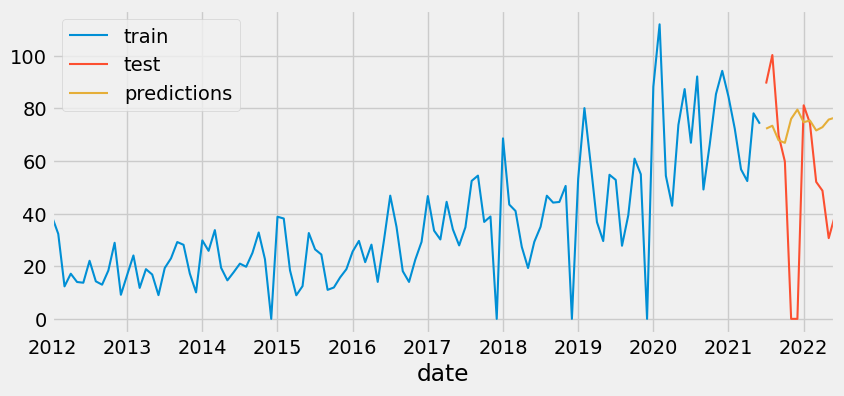

In [10]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [11]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 1468.0961067611213


In [12]:
# Hyperparameter Grid search
# ==============================================================================
steps = 12
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    param_grid  = param_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best = True,
                    verbose     = False
               )


Number of models compared: 6.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 573.3985079783426



In [13]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
4,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",573.398508,10,100
5,custom predictors,"{'max_depth': 10, 'n_estimators': 500}",578.176875,10,500
3,custom predictors,"{'max_depth': 5, 'n_estimators': 500}",584.576636,5,500
1,custom predictors,"{'max_depth': 3, 'n_estimators': 500}",591.399827,3,500
2,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",600.019929,5,100
0,custom predictors,"{'max_depth': 3, 'n_estimators': 100}",603.111899,3,100


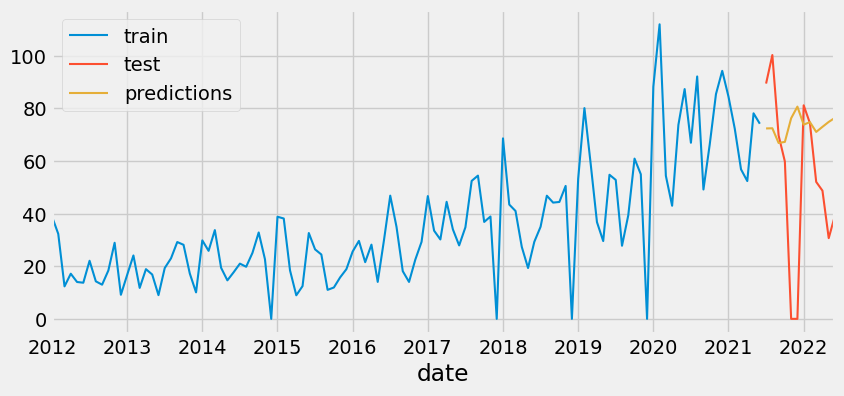

In [14]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [15]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 1483.36849136588


In [17]:
# Create and train forecaster: ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 12,
                lags          = 8
             )

forecaster

ForecasterAutoregDirect 
Regressor: Lasso(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Included weights function: False 
Window size: 8 
Maximum steps predicted: 12 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': 123, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
Creation date: 2023-01-28 08:31:23 
Last fit date: None 
Skforecast version: 0.6.0 
Python version: 3.10.8 

In [18]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 12,
                lags          = 8 # This value will be replaced in the grid search
             )

# To access parameters of a scikitlearn pipeline the pattern:
# <name of the step>__<name of the parameter>.
param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data_train['y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 12,
                    refit              = True,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False
                )


Number of models compared: 30.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:01<00:00,  2.02it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 0.021544346900318846}
  Backtesting metric: 483.99744210664846



In [19]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,alpha
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.021544346900318846},483.997442,0.021544
0,"[1, 2, 3, 4, 5]",{'alpha': 1e-05},499.975048,0.000010
1,"[1, 2, 3, 4, 5]",{'alpha': 0.0001291549665014884},499.981747,0.000129
2,"[1, 2, 3, 4, 5]",{'alpha': 0.0016681005372000592},500.119711,0.001668
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.0016681005372000592},506.837915,0.001668


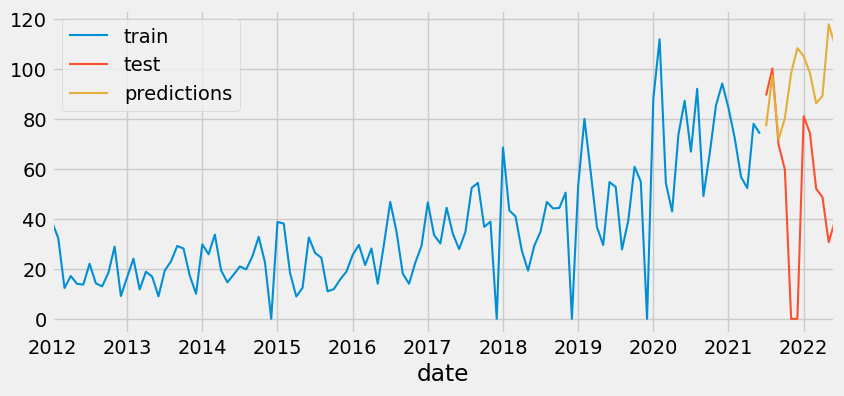

In [20]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();


In [21]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 3213.7167646019066
